In [62]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
!pip install giotto-tda
!pip install --upgrade umap-learn

  Using cached scikit_learn-1.3.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp312-cp312-macosx_12_0_arm64.whl (9.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.2
    Uninstalling scikit-learn-1.7.2:
      Successfully uninstalled scikit-learn-1.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
  Using cached scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl (8.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not curre

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_moons, make_circles
from umap import UMAP
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

In [13]:
def generate_data(dataset="donuts", n_samples=500, noise=0.1):
    if dataset == "moons":
        X, y = make_moons(n_samples=n_samples, noise=noise)
    elif dataset == "donuts":
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    return X, y

In [14]:
def normalize_activations(a, mode="zscore"):
    """Normalize layer activations for fair comparison."""
    if mode == "zscore":
        a = (a - a.mean(0)) / (a.std(0) + 1e-8)
    elif mode == "unit":
        a = F.normalize(a, p=2, dim=1)
    return a

In [29]:
def plot_umap_3d(activations, y, title_prefix="Layer", normalize=True):
    fig = plt.figure(figsize=(15, 3 * len(activations)))

    for i, a in enumerate(activations):
        if normalize:
            a = normalize_activations(a)

        #reducer = umap.UMAP(n_components=3, random_state=42)
        reducer = UMAP(n_components=3, random_state=42)
        reduced = reducer.fit_transform(a.detach().cpu().numpy())

        ax = fig.add_subplot(1, len(activations), i + 1, projection="3d")
        scatter = ax.scatter(
            reduced[:, 0], reduced[:, 1], reduced[:, 2],
            c=y, cmap="coolwarm", s=10
        )
        ax.set_title(f"{title_prefix} {i + 1}", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

    plt.tight_layout()
    plt.show()

In [43]:
def compute_persistent_homology(activations, max_dim=2, max_edge=2.0):
    """Compute Betti numbers via Vietoris–Rips persistence."""
    VR = VietorisRipsPersistence(
        homology_dimensions=list(range(max_dim + 1)),
        metric="euclidean",
        n_jobs=-1,
        max_edge_length=max_edge
    )

    diagrams = []
    betti_numbers = []

    for a in activations:
        a_np = normalize_activations(a).detach().cpu().numpy()
        diag = VR.fit_transform([a_np])[0]
        diagrams.append(diag)

        # Compute Betti counts from diagram entries
        betti = [np.sum(diag[:, 2] == dim) for dim in range(max_dim + 1)]
        betti_numbers.append(betti)

    return diagrams, betti_numbers

def plot_persistence_diagrams(diagrams, title_prefix="Layer"):
    """Plot persistence diagrams without using gtda's plot_diagram."""
    for i, diag in enumerate(diagrams):
        plt.figure(figsize=(5, 5))

        if diag.size == 0:
            plt.title(f"{title_prefix} {i + 1} (empty diagram)")
            plt.show()
            continue

        # Remove infinite deaths for visualization
        finite_diag = diag[np.isfinite(diag[:, 1])]

        if finite_diag.size == 0:
            plt.title(f"{title_prefix} {i + 1} (no finite points)")
            plt.show()
            continue

        # Separate by dimension for color coding
        dims = finite_diag[:, 2].astype(int)
        colors = {0: 'red', 1: 'blue', 2: 'green'}
        labels = {0: 'H0 (connected)', 1: 'H1 (loops)', 2: 'H2 (voids)'}

        # Plot points by dimension
        for dim in np.unique(dims):
            mask = dims == dim
            points = finite_diag[mask]
            plt.scatter(
                points[:, 0],
                points[:, 1],
                c=colors.get(dim, 'black'),
                label=labels.get(dim, f'H{dim}'),
                s=50,
                alpha=0.7,
                edgecolors='black',
                linewidth=0.5
            )

        # Diagonal line (persistence = 0)
        max_val = np.max(finite_diag) * 1.1
        plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1)

        # Formatting
        plt.xlim(-0.05 * max_val, max_val)
        plt.ylim(-0.05 * max_val, max_val)
        plt.xlabel("Birth", fontsize=11)
        plt.ylabel("Death", fontsize=11)
        plt.title(f"{title_prefix} {i + 1} Persistence Diagram", fontsize=12)
        plt.legend(loc='upper left', fontsize=9)
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.gca().set_aspect('equal')
        plt.tight_layout()
        plt.show()

In [45]:
def compute_layer_volumes(
    activations,
    normalize_fn=normalize_activations,
    per_dimension=True,
    skip_last_layer=False,
    jitter=1e-6,
    eps=1e-8
):
    log_vols = []
    acts = activations[:-1] if skip_last_layer else activations

    for a in acts:
        A = normalize_fn(a).detach().cpu().numpy()        # (N, d)
        cov = np.cov(A.T)
        cov += np.eye(cov.shape[0]) * jitter              # stability
        _, S, _ = np.linalg.svd(cov, full_matrices=False)
        lv = np.sum(np.log(S + eps))
        if per_dimension:
            lv /= cov.shape[0]
        log_vols.append(lv)
    return log_vols

def plot_volumes(vol_small, vol_deep):
    plt.figure(figsize=(7, 4))
    plt.plot(vol_small, marker='o', label='SmallNet log-volume')
    plt.plot(vol_deep, marker='o', label='DeepNet log-volume', linestyle='--')
    plt.title("Layer-wise Log Volume of Covariance")
    plt.xlabel("Layer")
    plt.ylabel("log(det(cov))")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons, make_circles
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [49]:
class SmallMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=3, out_dim=2):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(in_dim, hidden),
            nn.Linear(hidden, hidden),
            nn.Linear(hidden, out_dim)
        ])

    def forward(self, x):
        activations = []
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
            activations.append(x.detach())
        x = self.layers[-1](x)
        activations.append(x.detach())
        return x, activations

class DeepMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=6, out_dim=2, depth=6):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(in_dim, hidden)])
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden, hidden))
        self.layers.append(nn.Linear(hidden, out_dim))

    def forward(self, x):
        activations = []
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
            activations.append(x.detach())
        x = self.layers[-1](x)
        activations.append(x.detach())
        return x, activations
def train_model(model, X, y, epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out, _ = model(X)
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
    return model

In [51]:
X, y = generate_data("donuts")

small_net = SmallMLP()
deep_net = DeepMLP()

small_net = train_model(small_net, X, y)
deep_net = train_model(deep_net, X, y)

_, small_acts = small_net(X)
_, deep_acts = deep_net(X)

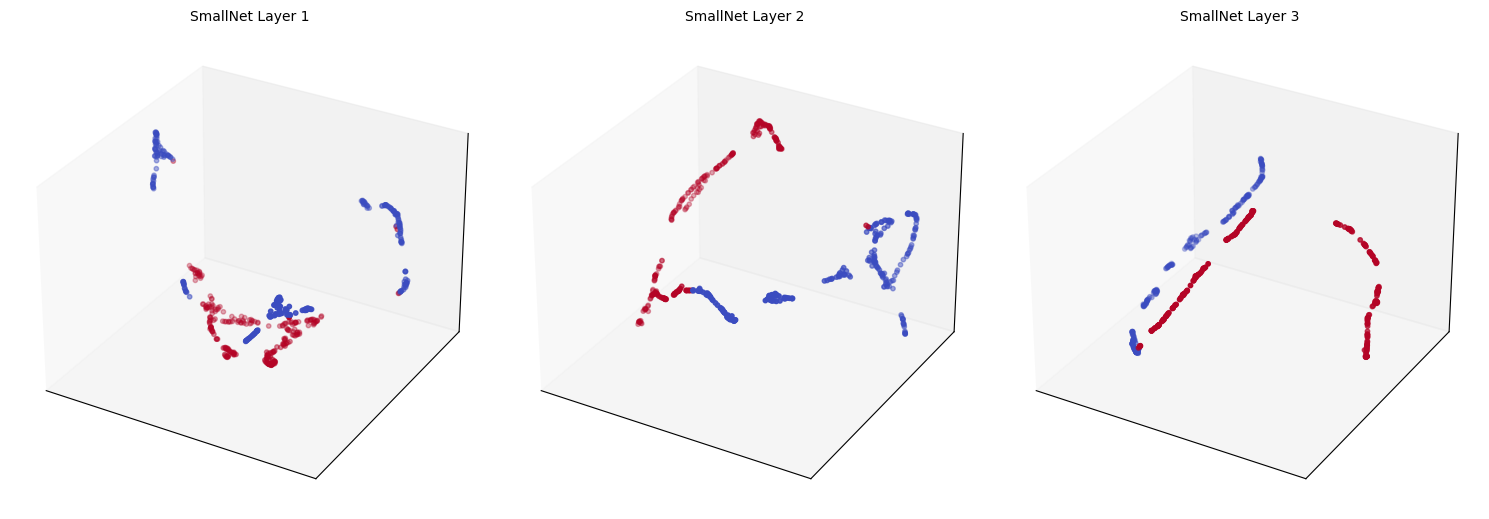

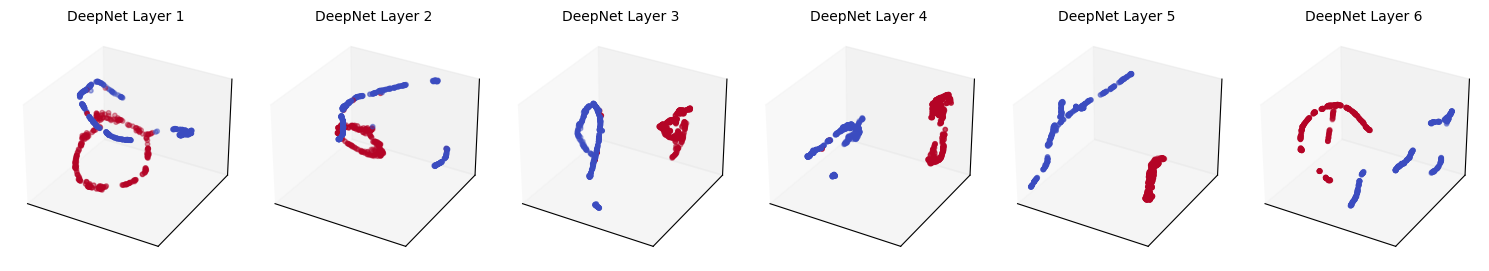

In [52]:
plot_umap_3d(small_acts, y, title_prefix="SmallNet Layer")
plot_umap_3d(deep_acts, y, title_prefix="DeepNet Layer")

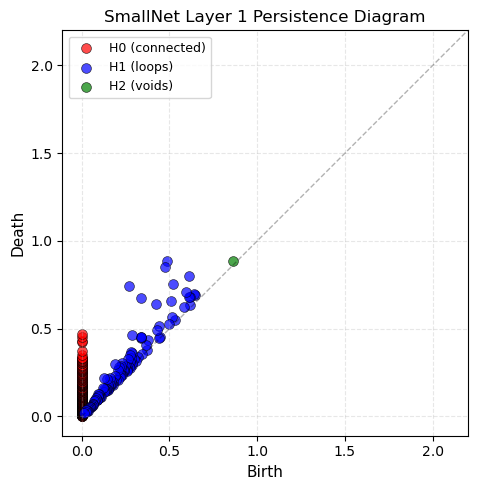

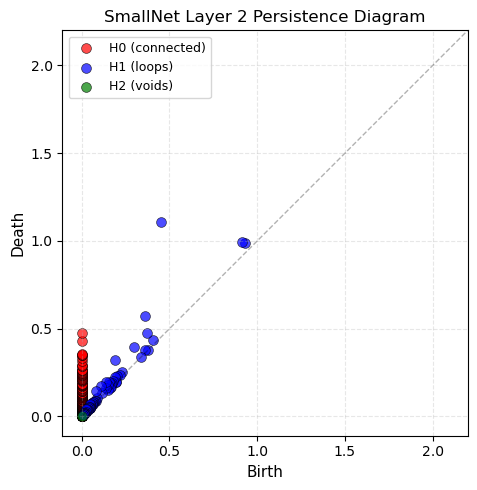

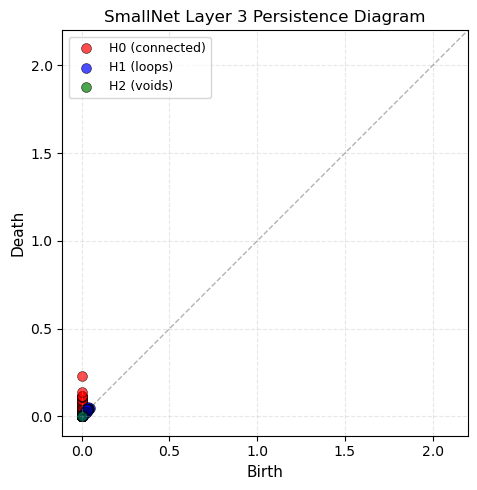

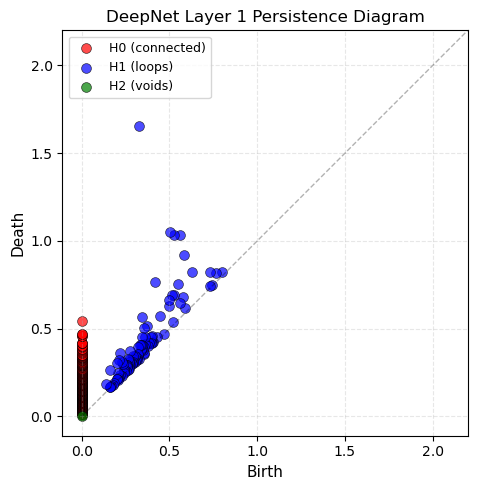

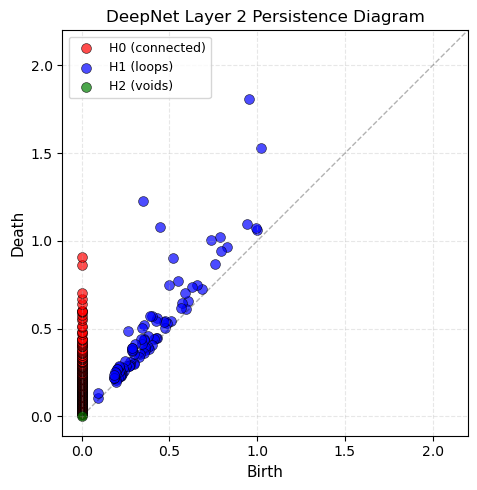

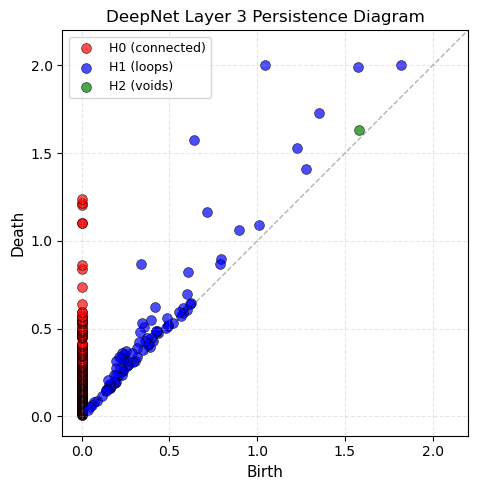

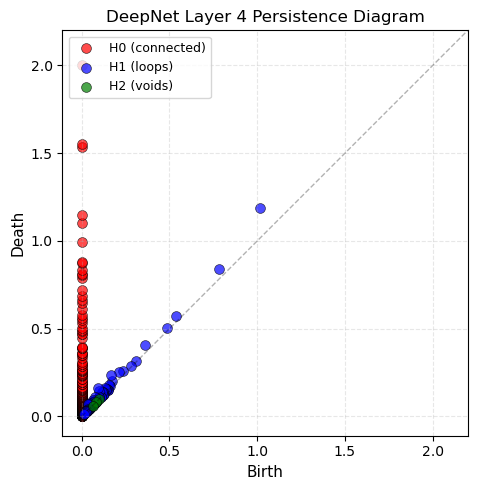

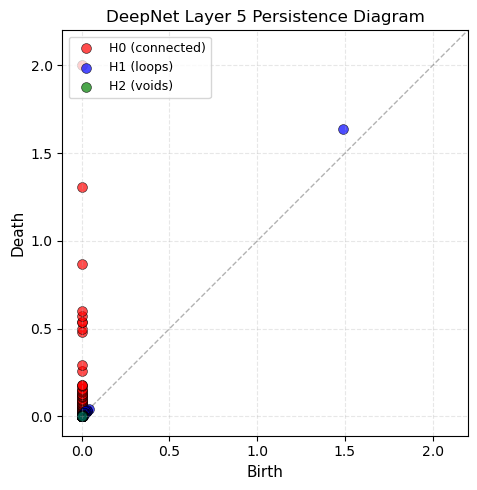

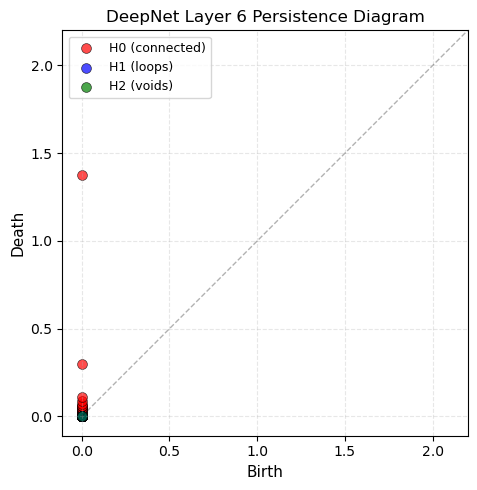

SmallNet Betti numbers per layer: [[499, 112, 1], [499, 64, 1], [499, 34, 1]]
DeepNet Betti numbers per layer: [[499, 98, 1], [499, 88, 1], [499, 89, 1], [499, 87, 3], [499, 60, 1], [499, 11, 1]]


In [54]:
small_diagrams, small_betti = compute_persistent_homology(small_acts)
deep_diagrams, deep_betti = compute_persistent_homology(deep_acts)

plot_persistence_diagrams(small_diagrams, title_prefix="SmallNet Layer")
plot_persistence_diagrams(deep_diagrams, title_prefix="DeepNet Layer")

print("SmallNet Betti numbers per layer:", small_betti)
print("DeepNet Betti numbers per layer:", deep_betti)

In [55]:
small_vols = compute_layer_volumes(
    small_acts,
    per_dimension=True,
    skip_last_layer=False
)
deep_vols  = compute_layer_volumes(
    deep_acts,
    per_dimension=True,
    skip_last_layer=False
)
plot_volumes(small_volumes, deep_volumes)

print("SmallNet layer volumes:", small_volumes)
print("DeepNet layer volumes:", deep_volumes)

NameError: name 'small_volumes' is not defined

In [ ]:
def plot_betti_trends(betti_small, betti_deep, title_prefix="Betti Trends"):
    """Plot Betti numbers (H0, H1, H2) vs. layer depth for both models."""
    betti_small = np.array(betti_small)
    betti_deep = np.array(betti_deep)
    dims = ['H0 (connected)', 'H1 (loops)', 'H2 (voids)']
    colors = ['tab:red', 'tab:blue', 'tab:green']

    plt.figure(figsize=(8, 5))
    for i in range(min(betti_small.shape[1], 3)):
        plt.plot(betti_small[:, i], '-o', color=colors[i], label=f"SmallNet {dims[i]}")
        plt.plot(betti_deep[:, i], '--o', color=colors[i], alpha=0.6, label=f"DeepNet {dims[i]}")

    plt.title(f"{title_prefix}: Topological Simplification Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("Count (Betti number)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_betti_trends(small_betti, deep_betti)


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
subset_indices = np.random.choice(len(mnist), 1000, replace=False)  # small subset
mnist_subset = Subset(mnist, subset_indices)
loader = DataLoader(mnist_subset, batch_size=1000, shuffle=False)

X_img, y_img = next(iter(loader))
X_img = X_img.view(X_img.size(0), -1)  # flatten
y_img = y_img

In [16]:
class MNISTMLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(28*28, 256),
            torch.nn.Linear(256, 128),
            torch.nn.Linear(128, 64),
            torch.nn.Linear(64, 10)
        ])
    def forward(self, x):
        activations = []
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
            activations.append(x.detach())
        x = self.layers[-1](x)
        activations.append(x.detach())
        return x, activations

In [17]:
def train_mnist(model, X, y, epochs=5, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out, _ = model(X)
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
    return model

In [18]:
import torch.nn.functional as F

In [19]:
mnist_mlp = MNISTMLP()
mnist_mlp = train_mnist(mnist_mlp, X_img, y_img)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


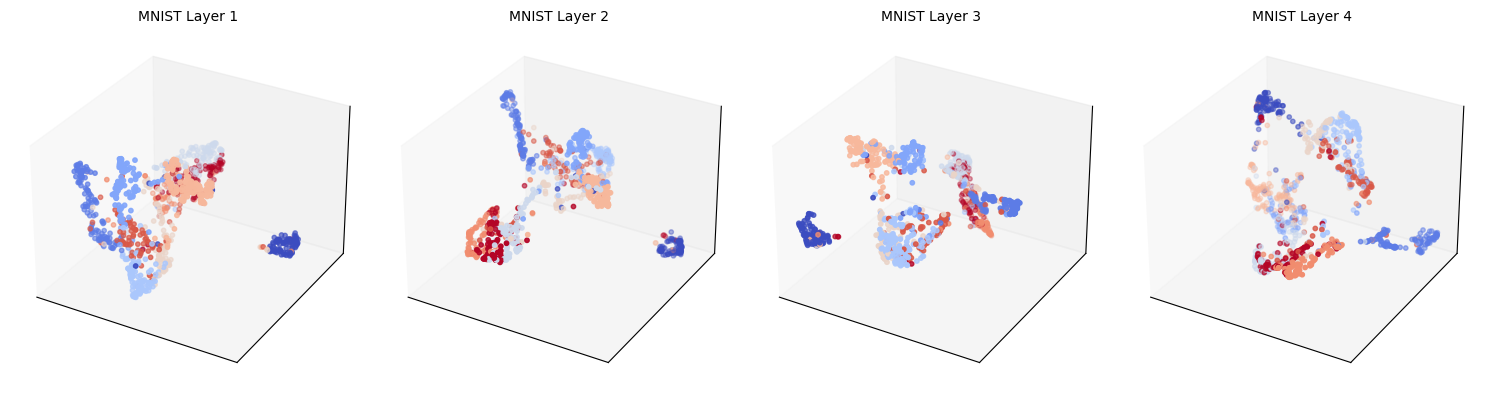

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

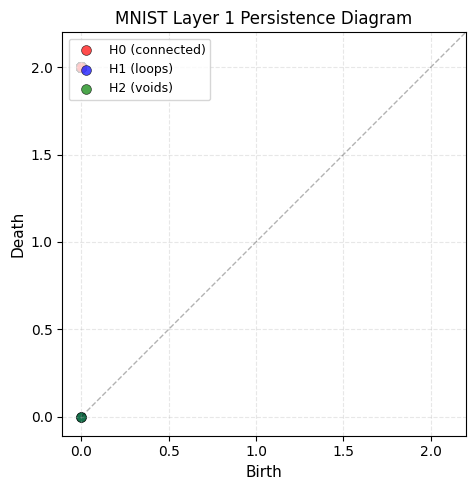

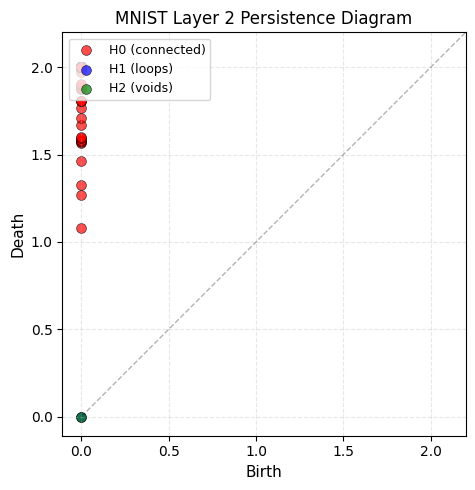

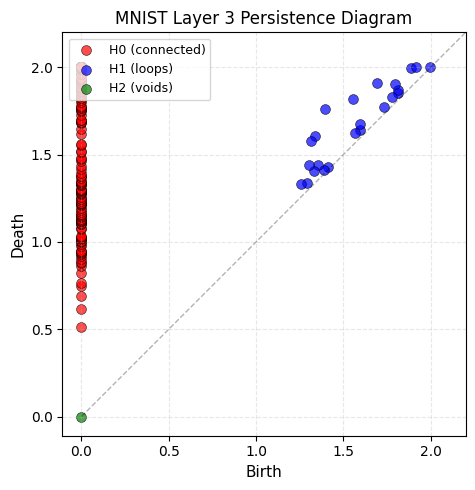

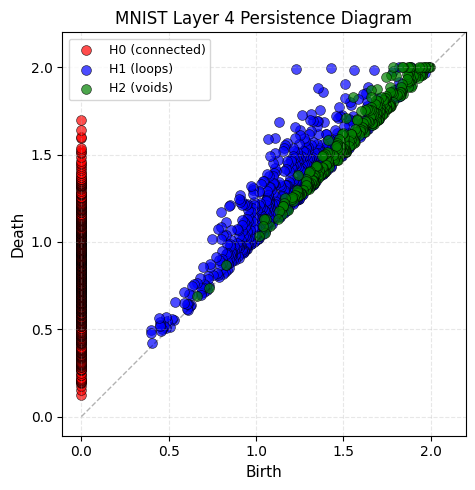

In [20]:
_, mnist_acts = mnist_mlp(X_img)
plot_umap_3d(mnist_acts, y_img, title_prefix="MNIST Layer")
mnist_diagrams, mnist_betti = compute_persistent_homology(mnist_acts)
plot_persistence_diagrams(mnist_diagrams, title_prefix="MNIST Layer")
mnist_volumes = compute_layer_volumes(mnist_acts)

In [21]:
def plot_single_model_volumes(volumes, model_label="MNIST MLP"):
    """Plot per-layer log-volume for a single network."""
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(volumes) + 1), volumes, marker='o')
    plt.title(f"Layer-wise Log Volume ({model_label})")
    plt.xlabel("Layer")
    plt.ylabel("log(det(Covariance))")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


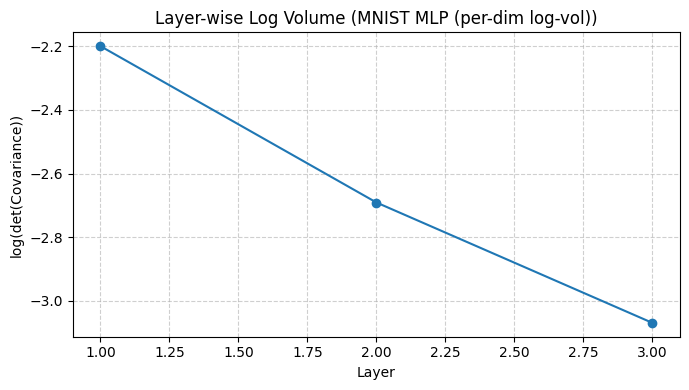

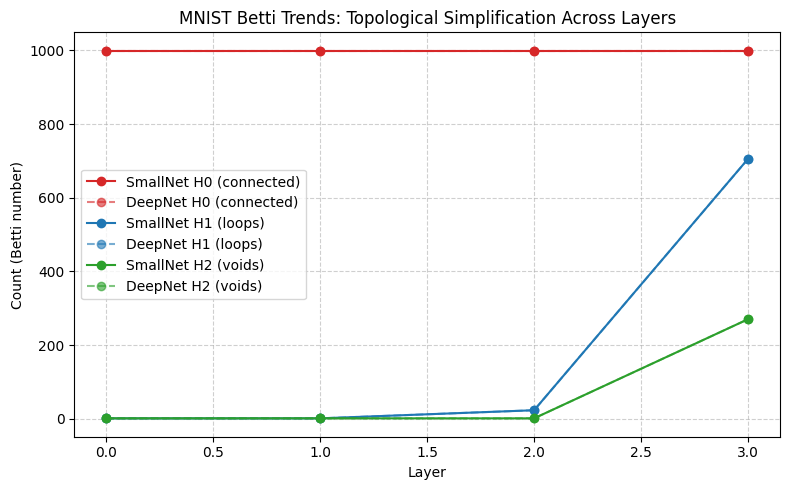

In [31]:

def compute_layer_volumes(
    activations,
    normalize_activations_fn=normalize_activations,
    per_dimension=True,
    skip_last_layer=False
):
    """
    Compute log-volume = log det(cov) of each layer’s activations.
    If per_dimension=True, returns (1/d) * log det(cov) so you can compare
    layers of different dimensionality on the same scale.
    If skip_last_layer=True, drops the final activation (e.g. the logits).
    """
    log_vols = []
    acts = activations[:-1] if skip_last_layer else activations

    for a in acts:
        a_np = normalize_activations_fn(a).detach().cpu().numpy()  # (N, d)
        cov = np.cov(a_np.T)
        cov += np.eye(cov.shape[0]) * 1e-6                         # numerical stab
        _, S, _ = np.linalg.svd(cov)
        log_det = np.sum(np.log(S + 1e-12))
        if per_dimension:
            d = cov.shape[0]
            log_det = log_det / d
        log_vols.append(log_det)

    return log_vols
# only hidden tanh layers, and compute per-dim log-volume
mnist_vols = compute_layer_volumes(
    mnist_acts,
    per_dimension=True,
    skip_last_layer=True
)
plot_single_model_volumes(mnist_vols, model_label="MNIST MLP (per-dim log-vol)")
plot_betti_trends(mnist_betti, mnist_betti, title_prefix="MNIST Betti Trends")

In [23]:
print("MNIST Betti numbers per layer:", mnist_betti)
print("MNIST layer log-volumes:", mnist_volumes)

MNIST Betti numbers per layer: [[999, 1, 1], [999, 1, 1], [999, 23, 1], [999, 705, 270]]
MNIST layer log-volumes: [-563.1092156444145, -344.4243381740416, -196.41757379543066, -15.339381230086572]


In [24]:
from torchvision.models import alexnet
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

In [25]:
model = alexnet(pretrained=True).features
model.eval()

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
cifar = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
loader = DataLoader(cifar, batch_size=128, shuffle=False)

imgs, labels = next(iter(loader))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 202MB/s]
100%|██████████| 170M/170M [00:08<00:00, 20.7MB/s]


In [26]:
activations = []
x = imgs
for i, layer in enumerate(model):
    x = layer(x)
    if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Conv2d):
        flat = x.view(x.size(0), -1)
        activations.append(flat.detach())

Processing layer 1/10...
  Input shape: freed -> Final: (50, 8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Processing layer 2/10...
  Input shape: freed -> Final: (50, 8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Processing layer 3/10...
  Input shape: freed -> Final: (50, 8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Processing layer 4/10...
  Input shape: freed -> Final: (50, 8)
Processing layer 5/10...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Input shape: freed -> Final: (50, 8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Processing layer 6/10...
  Input shape: freed -> Final: (50, 8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Processing layer 7/10...
  Input shape: freed -> Final: (50, 8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Processing layer 8/10...
  Input shape: freed -> Final: (50, 8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Processing layer 9/10...
  Input shape: freed -> Final: (50, 8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Processing layer 10/10...
  Input shape: freed -> Final: (50, 8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing volume 1/10...
Computing volume 2/10...
Computing volume 3/10...
Computing volume 4/10...
Computing volume 5/10...
Computing volume 6/10...
Computing volume 7/10...
Computing volume 8/10...
Computing volume 9/10...
Computing volume 10/10...


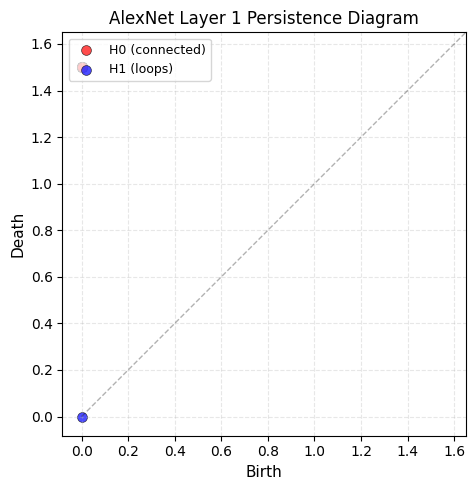

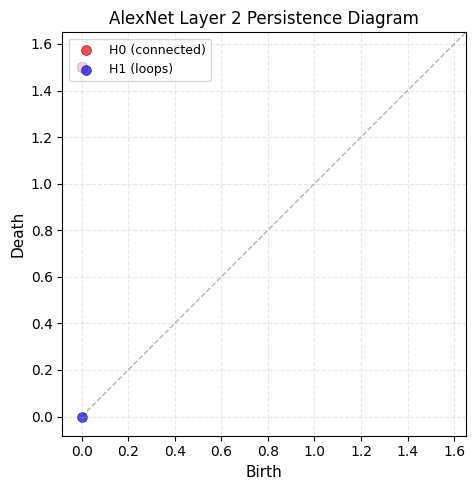

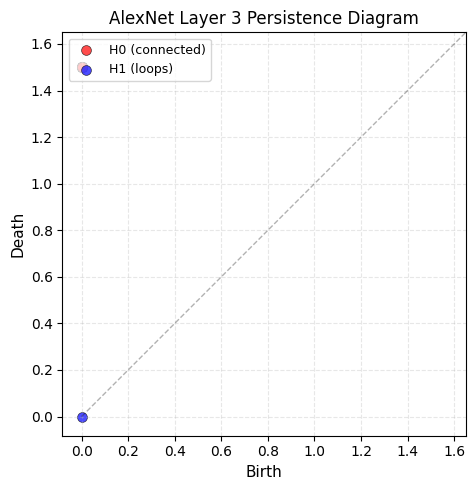

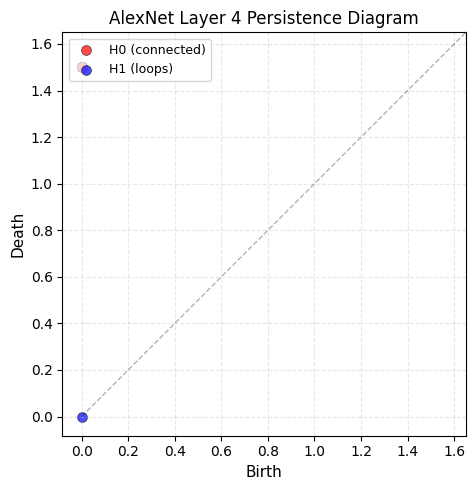

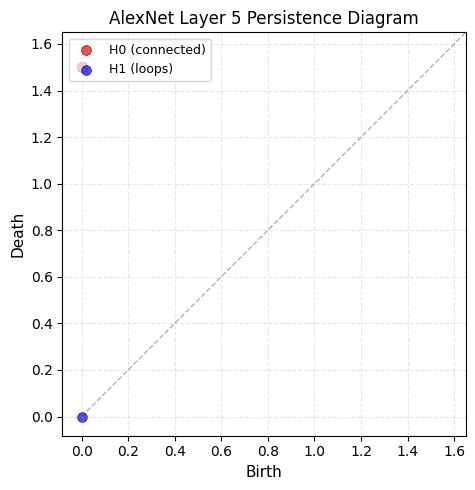

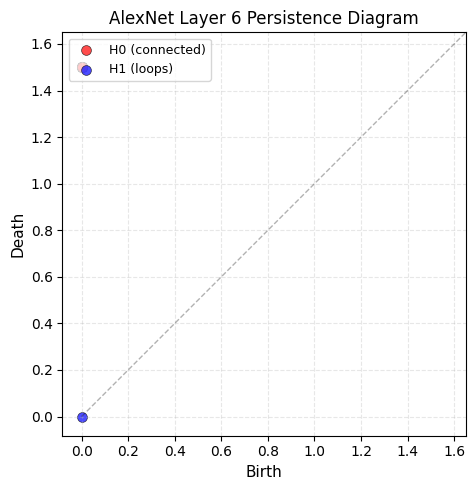

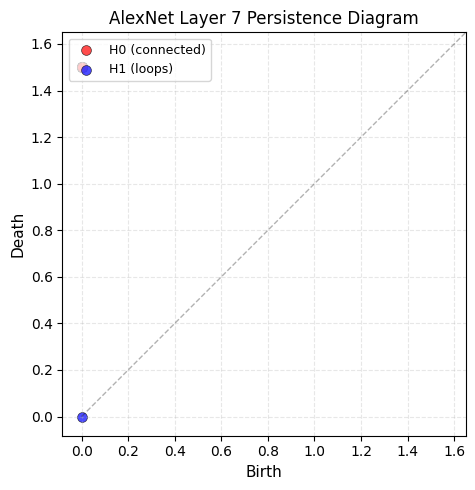

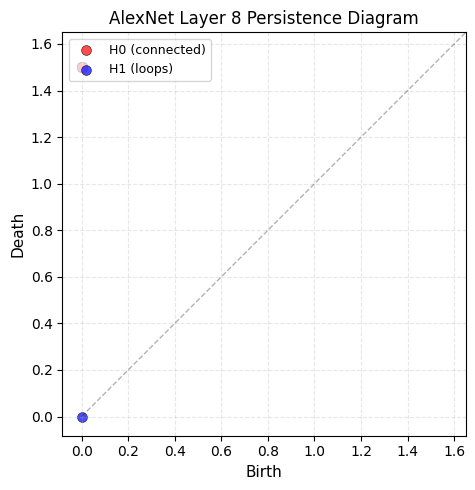

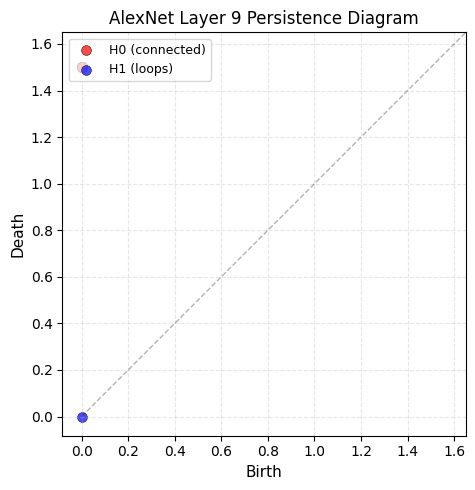

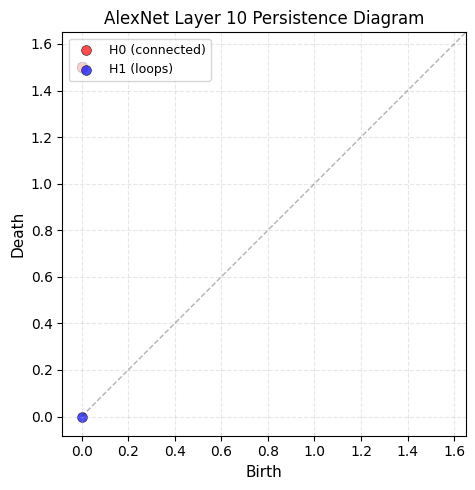

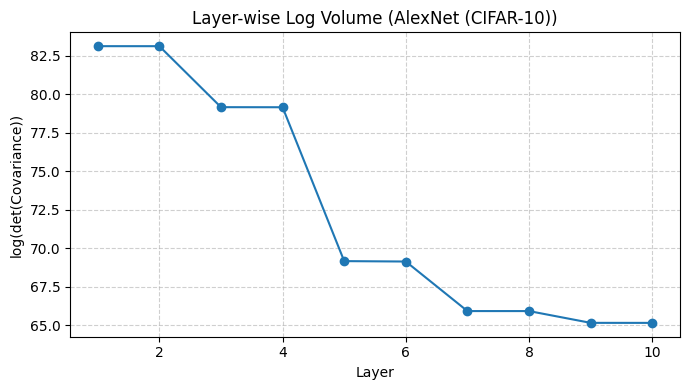

In [27]:
# def compute_persistent_homology_efficient(activations, max_dim=1, max_edge=2.0, pca_dim=15, n_samples=300):
#     """PCA + subsampling for efficiency."""
#     VR = VietorisRipsPersistence(
#         homology_dimensions=list(range(max_dim + 1)),
#         metric="euclidean",
#         n_jobs=-1,
#         max_edge_length=max_edge
#     )
#     diagrams = []
#     betti_numbers = []
#     for a in activations:
#         a_np = normalize_activations(a).detach().cpu().numpy()
#         # Subsample first
#         idx = np.random.choice(a_np.shape[0], min(n_samples, a_np.shape[0]), replace=False)
#         a_sampled = a_np[idx]
#         # Then PCA
#         pca = PCA(n_components=min(pca_dim, a_sampled.shape[1]))
#         a_reduced = pca.fit_transform(a_sampled)
#         diag = VR.fit_transform([a_reduced])[0]
#         diagrams.append(diag)
#         betti = [np.sum(diag[:, 2] == dim) for dim in range(max_dim + 1)]
#         betti_numbers.append(betti)
#     return diagrams, betti_numbers

# cifar_diagrams, cifar_betti = compute_persistent_homology_efficient(activations, max_dim=1)


import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from gtda.homology import VietorisRipsPersistence
import gc

def compute_persistent_homology_ultra_efficient(
    activations,
    max_dim=1,
    max_edge=1.5,
    pca_dim=8,
    n_samples=150,
    n_clusters=50
):
    """
    Ultra-efficient persistence computation:
    1. Aggressive PCA reduction
    2. Subsample data
    3. K-means clustering for representative points
    4. Smaller max_edge to reduce computation
    """
    VR = VietorisRipsPersistence(
        homology_dimensions=list(range(max_dim + 1)),
        metric="euclidean",
        n_jobs=1,  # Single job to avoid memory overhead
        max_edge_length=max_edge
    )

    diagrams = []
    betti_numbers = []

    for layer_idx, a in enumerate(activations):
        print(f"Processing layer {layer_idx + 1}/{len(activations)}...")

        # Step 1: Normalize
        a_np = normalize_activations(a).detach().cpu().numpy()
        del a  # Free memory immediately
        gc.collect()

        # Step 2: Aggressive PCA first (reduces memory early)
        pca_dim_actual = min(pca_dim, a_np.shape[1])
        pca = PCA(n_components=pca_dim_actual, random_state=42)
        a_pca = pca.fit_transform(a_np)
        del a_np, pca
        gc.collect()

        # Step 3: Subsample
        n_samples_actual = min(n_samples, a_pca.shape[0])
        idx = np.random.choice(a_pca.shape[0], n_samples_actual, replace=False)
        a_sampled = a_pca[idx]
        del a_pca
        gc.collect()

        # Step 4: K-means on sampled data (use cluster centers instead)
        if a_sampled.shape[0] > n_clusters:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            a_final = kmeans.fit_predict(a_sampled)
            a_final = kmeans.cluster_centers_  # Use centers
            del kmeans, a_sampled
        else:
            a_final = a_sampled
        gc.collect()

        print(f"  Input shape: {a_np.shape if 'a_np' in locals() else 'freed'} -> Final: {a_final.shape}")

        # Step 5: Compute persistence (small input now)
        try:
            diag = VR.fit_transform([a_final])[0]
            diagrams.append(diag)
            betti = [np.sum(diag[:, 2] == dim) for dim in range(max_dim + 1)]
            betti_numbers.append(betti)
        except Exception as e:
            print(f"  Warning: Persistence computation failed: {e}")
            diagrams.append(np.array([]))
            betti_numbers.append([0] * (max_dim + 1))

        del a_final, diag
        gc.collect()

    return diagrams, betti_numbers


def compute_layer_volumes_efficient(activations):
    """Memory-efficient volume computation."""
    log_volumes = []
    for i, a in enumerate(activations):
        print(f"Computing volume {i + 1}/{len(activations)}...")
        a_np = normalize_activations(a).detach().cpu().numpy()

        # PCA to reduce before covariance
        pca = PCA(n_components=min(10, a_np.shape[1]))
        a_reduced = pca.fit_transform(a_np)

        cov = np.cov(a_reduced.T)
        cov += np.eye(cov.shape[0]) * 1e-6
        U, S, _ = np.linalg.svd(cov)
        log_vol = np.sum(np.log(S + 1e-8))
        log_volumes.append(log_vol)

        del a_np, a_reduced, cov, U, S
        gc.collect()

    return log_volumes


# Usage:
cifar_diagrams, cifar_betti = compute_persistent_homology_ultra_efficient(
    activations,
    max_dim=1,
    max_edge=1.5,
    pca_dim=8,          # Very aggressive reduction
    n_samples=150,      # Small sample
    n_clusters=50       # Use cluster centers
)

cifar_volumes = compute_layer_volumes_efficient(activations)

plot_persistence_diagrams(cifar_diagrams, title_prefix="AlexNet Layer")
plot_single_model_volumes(cifar_volumes, model_label="AlexNet (CIFAR-10)")

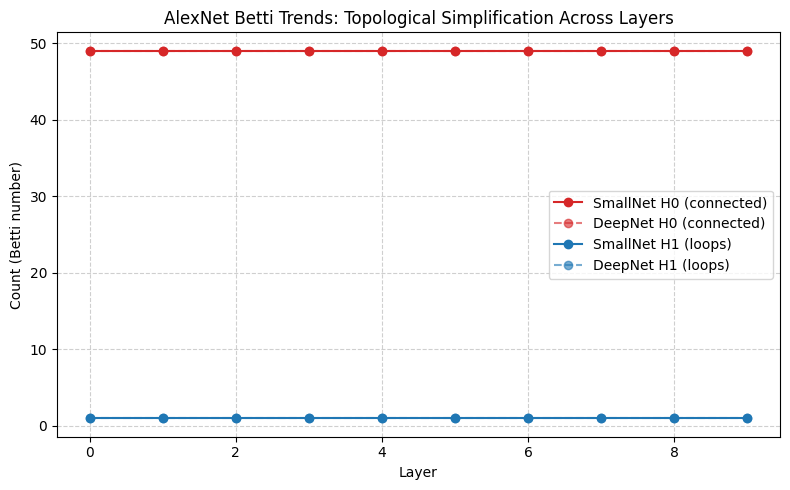

In [28]:
# plot_persistence_diagrams(cifar_diagrams, title_prefix="AlexNet Layer")
# cifar_volumes = compute_layer_volumes(activations)
# plot_single_model_volumes(cifar_volumes, model_label="AlexNet (CIFAR-10)")
plot_betti_trends(cifar_betti, cifar_betti, title_prefix="AlexNet Betti Trends")

In [29]:
print("AlexNet Betti per layer:", cifar_betti)
print("AlexNet log-volumes:", cifar_volumes)

AlexNet Betti per layer: [[49, 1], [49, 1], [49, 1], [49, 1], [49, 1], [49, 1], [49, 1], [49, 1], [49, 1], [49, 1]]
AlexNet log-volumes: [83.13870736359674, 83.13780479964112, 79.172771323868, 79.16804750597362, 69.16449698877628, 69.13838398543183, 65.91751570045241, 65.91672580881331, 65.15103396089911, 65.14923186010269]


In [72]:
import numpy as np
import matplotlib.pyplot as plt

def compute_covariance_volume_by_class(activations, labels):
    """
    activations: list of tensors [layer1_act, layer2_act, ...]
                 each of shape (N, D)
    labels: numpy array or tensor of shape (N,)
    
    Returns:
        volumes_per_class: dict {class_id: [vol_layer1, vol_layer2, ...]}
    """
    labels_np = labels.numpy() if not isinstance(labels, np.ndarray) else labels
    classes = np.unique(labels_np)
    volumes_per_class = {cls: [] for cls in classes}

    for layer_act in activations:
        X = layer_act.numpy()
        for cls in classes:
            class_data = X[labels_np == cls]
            if len(class_data) > 1:
                cov = np.cov(class_data, rowvar=False)
                # Add small regularizer to avoid singular covariance
                cov += np.eye(cov.shape[0]) * 1e-6
                det = np.linalg.det(cov)
                vol = np.sqrt(det) if det > 0 else 0
            else:
                vol = 0
            volumes_per_class[cls].append(vol)
    return volumes_per_class


def plot_covariance_volume_change(volumes_per_class, title="Covariance Volume per Class Across Layers"):
    plt.figure(figsize=(8,6))
    for cls, vols in volumes_per_class.items():
        plt.plot(range(1, len(vols)+1), vols, marker='o', label=f'Class {cls}')
    plt.xlabel("Layer")
    plt.ylabel("Covariance Volume (sqrt(det Σ))")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def normalize_volumes(volumes_per_class):
    normed = {}
    for cls, vols in volumes_per_class.items():
        base = vols[0] if vols[0] != 0 else 1
        normed[cls] = [v / base for v in vols]
    return normed


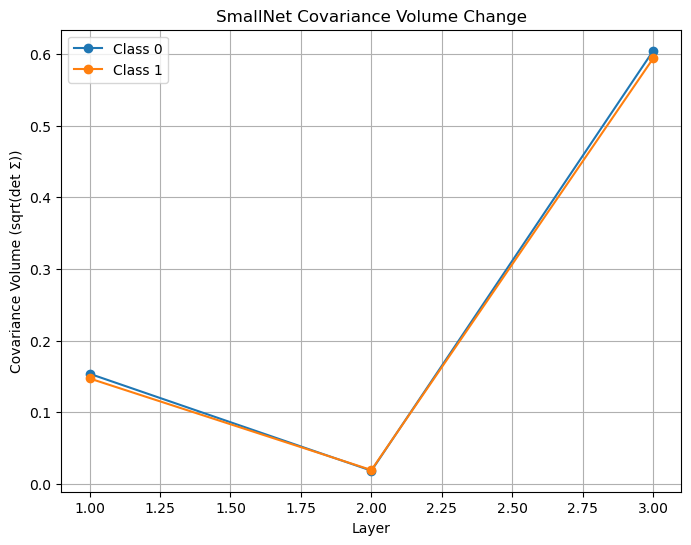

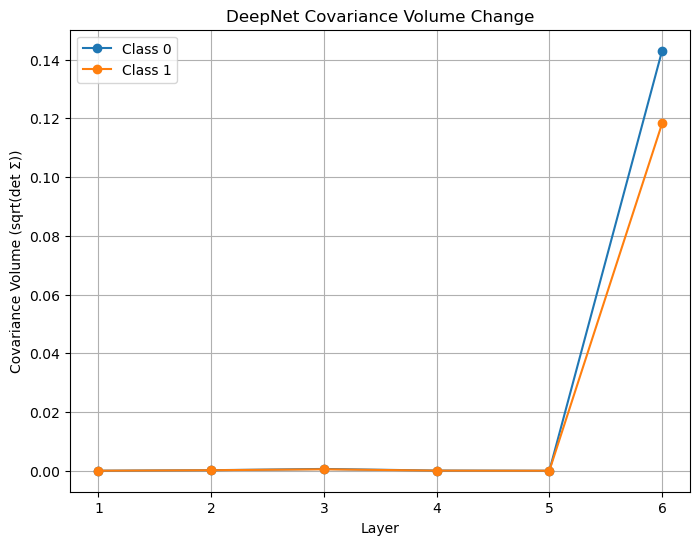

In [74]:
from sklearn.datasets import make_moons
import torch

# Choose dataset: moons or circles
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
# Or: X, y = make_circles(n_samples=500, factor=0.5, noise=0.05, random_state=42)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(y, dtype=torch.long)


small_vols = compute_covariance_volume_by_class(small_acts, labels)
deep_vols = compute_covariance_volume_by_class(deep_acts, labels)
plot_covariance_volume_change(small_vols, "SmallNet Covariance Volume Change")
plot_covariance_volume_change(deep_vols, "DeepNet Covariance Volume Change")


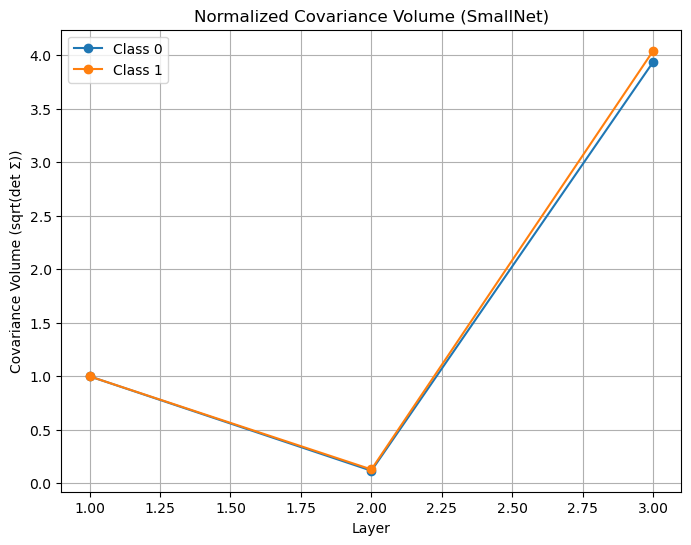

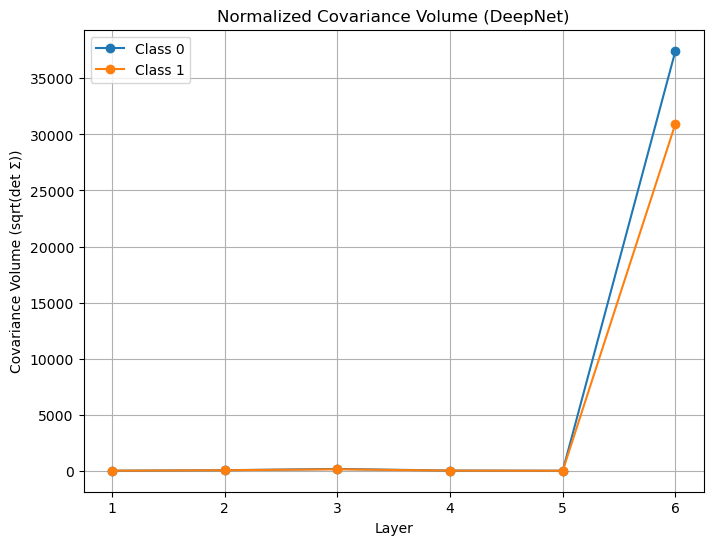

In [76]:
small_vols_norm = normalize_volumes(small_vols)
deep_vols_norm = normalize_volumes(deep_vols)

plot_covariance_volume_change(small_vols_norm, "Normalized Covariance Volume (SmallNet)")
plot_covariance_volume_change(deep_vols_norm, "Normalized Covariance Volume (DeepNet)")


In [78]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# robust covariance volume per class (log-volume using slogdet for stability)
def class_cov_logvolume(activations, labels, eps=1e-6):
    """
    activations: list of torch.Tensor, each shape (N, D_l)
    labels: torch.Tensor or np.array shape (N,)
    returns: dict[class] = list of log-volumes per layer (natural log of sqrt(det) = 0.5 * logdet)
    """
    labels_np = labels.detach().cpu().numpy() if isinstance(labels, torch.Tensor) else np.array(labels)
    classes = np.unique(labels_np)
    logvols = {c: [] for c in classes}
    
    for layer_idx, A in enumerate(activations):
        A_np = A.detach().cpu().numpy()
        # flatten conv outputs if needed
        if A_np.ndim > 2:
            A_np = A_np.reshape(A_np.shape[0], -1)
        for c in classes:
            Xc = A_np[labels_np == c]
            if Xc.shape[0] <= 1:
                # insufficient samples -> mark NaN
                logvols[c].append(np.nan)
                continue
            cov = np.cov(Xc, rowvar=False)
            # regularize
            cov += np.eye(cov.shape[0]) * eps
            sign, logdet = np.linalg.slogdet(cov)
            if sign <= 0:
                # numerical or non-positive definite; record NaN
                logvol = np.nan
            else:
                # sqrt(det) -> log(sqrt(det)) = 0.5 * logdet
                logvol = 0.5 * logdet
            logvols[c].append(logvol)
    return logvols

def plot_logvolumes(logvols, title="Log-Covariance Volume per Class (0.5*logdet)"):
    plt.figure(figsize=(8,5))
    for c, lv in logvols.items():
        plt.plot(range(1, len(lv)+1), lv, marker='o', label=f"class {c}")
    plt.xlabel("Layer")
    plt.ylabel("0.5 * logdet(Σ + eps I)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# extra diagnostic functions
def per_layer_eigen_spectra(activations, labels, class_id=0, eps=1e-6):
    """Return eigenvalues per layer (sorted descending) for class `class_id`."""
    labels_np = labels.detach().cpu().numpy() if isinstance(labels, torch.Tensor) else np.array(labels)
    spectra = []
    for A in activations:
        A_np = A.detach().cpu().numpy()
        if A_np.ndim > 2:
            A_np = A_np.reshape(A_np.shape[0], -1)
        Xc = A_np[labels_np == class_id]
        if Xc.shape[0] <= 1:
            spectra.append(None); continue
        cov = np.cov(Xc, rowvar=False) + np.eye(Xc.shape[1]) * eps
        eigs = np.linalg.eigvalsh(cov)  # ascending
        spectra.append(np.sort(eigs)[::-1])  # descending
    return spectra

def plot_eigenspectra(spectra, title="Eigenvalue spectra per layer"):
    plt.figure(figsize=(10,6))
    for i, eigs in enumerate(spectra):
        if eigs is None: continue
        plt.semilogy(eigs, marker='o', label=f"Layer {i+1}")
    plt.xlabel("Eigen-index (sorted desc)")
    plt.ylabel("Eigenvalue (log scale)")
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

def between_within_stats(activations, labels):
    """Compute trace(S_b) and trace(S_w) per layer for two-class case (generalizable)."""
    labels_np = labels.detach().cpu().numpy() if isinstance(labels, torch.Tensor) else np.array(labels)
    classes = np.unique(labels_np)
    tb_list, tw_list = [], []
    for A in activations:
        A_np = A.detach().cpu().numpy()
        if A_np.ndim > 2:
            A_np = A_np.reshape(A_np.shape[0], -1)
        overall_mean = A_np.mean(axis=0)
        Sb = np.zeros((A_np.shape[1], A_np.shape[1]))
        Sw = np.zeros_like(Sb)
        for c in classes:
            Xc = A_np[labels_np == c]
            if Xc.shape[0] > 0:
                mean_c = Xc.mean(axis=0)
                Nc = Xc.shape[0]
                diff = (mean_c - overall_mean).reshape(-1,1)
                Sb += Nc * (diff @ diff.T)
                if Xc.shape[0] > 1:
                    Sw += np.cov(Xc, rowvar=False) * (Nc - 1)
        tb_list.append(np.trace(Sb))
        tw_list.append(np.trace(Sw))
    return tb_list, tw_list

def plot_between_within(tb, tw, title="Between/Within trace per layer"):
    plt.figure(figsize=(8,4))
    plt.plot(range(1,len(tb)+1), tb, marker='o', label="trace(S_b)")
    plt.plot(range(1,len(tw)+1), tw, marker='o', label="trace(S_w)")
    plt.xlabel("Layer")
    plt.ylabel("Trace value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


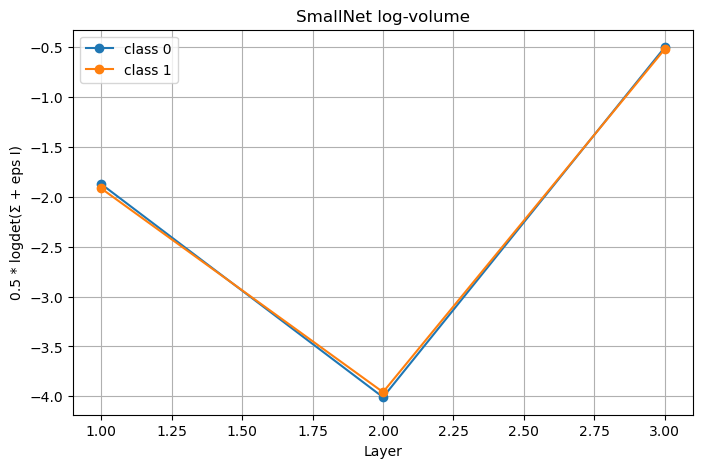

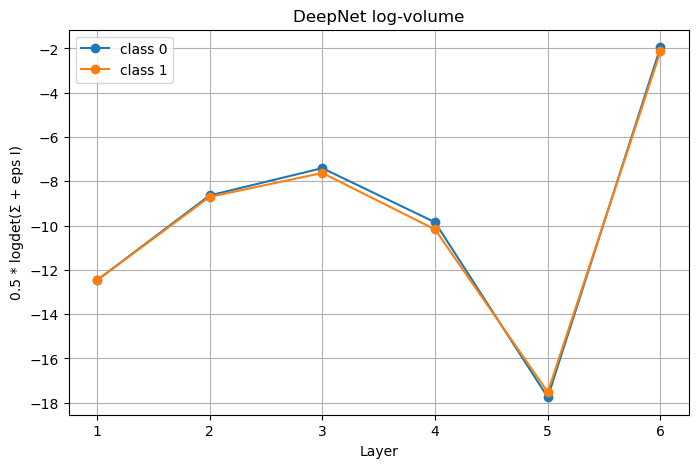

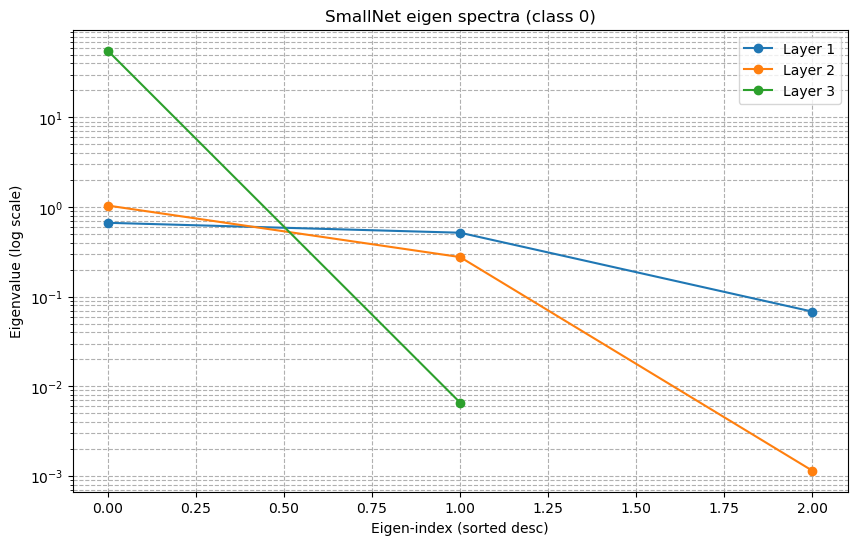

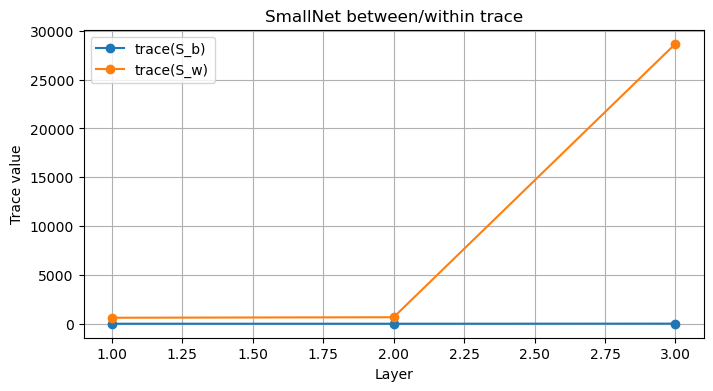

In [80]:
# assume: small_acts, deep_acts are lists of torch tensors (N x D_l) and labels is torch tensor (N,)
small_logvols = class_cov_logvolume_by_class = class_cov_logvolume(small_acts, labels, eps=1e-6)
deep_logvols  = class_cov_logvolume(deep_acts, labels, eps=1e-6)

plot_logvolumes(small_logvols, "SmallNet log-volume")
plot_logvolumes(deep_logvols, "DeepNet log-volume")

# For class 0 eigen spectra (example)
spectra0_small = per_layer_eigen_spectra(small_acts, labels, class_id=0)
plot_eigenspectra(spectra0_small, title="SmallNet eigen spectra (class 0)")

# Between/Within traces
tb_small, tw_small = between_within_stats(small_acts, labels)
plot_between_within(tb_small, tw_small, title="SmallNet between/within trace")


In [82]:
# --- Extract and store the covariance volume data (no plotting) ---
def get_covariance_volume_data(activations, labels, n_components=10):
    """
    Computes covariance volume change across layers per class
    and returns the raw data (no plotting).
    """
    import torch
    import numpy as np

    class_ids = torch.unique(labels).tolist()
    layer_volumes = {cls: [] for cls in class_ids}

    for layer_idx, acts in enumerate(activations):
        acts_np = acts.numpy()
        for cls in class_ids:
            class_mask = (labels == cls)
            class_acts = acts_np[class_mask]
            if class_acts.shape[0] < 2:
                layer_volumes[cls].append(np.nan)
                continue

            cov = np.cov(class_acts, rowvar=False)
            eigvals = np.linalg.eigvalsh(cov)
            volume = np.prod(eigvals[-n_components:] + 1e-8)
            layer_volumes[cls].append(volume)

    return layer_volumes


# --- Example Usage ---
small_vols = get_covariance_volume_data(small_acts, labels)
deep_vols = get_covariance_volume_data(deep_acts, labels)

# Print or inspect the data
import pandas as pd
small_df = pd.DataFrame(small_vols)
deep_df = pd.DataFrame(deep_vols)

print("SmallNet Covariance Volume Data:\n", small_df)
print("\nDeepNet Covariance Volume Data:\n", deep_df)

# If you want to save it to CSV for analysis:
small_df.to_csv("smallnet_cov_volumes.csv", index_label="Layer")
deep_df.to_csv("deepnet_cov_volumes.csv", index_label="Layer")


SmallNet Covariance Volume Data:
           0         1
0  0.023599  0.021619
1  0.000330  0.000365
2  0.365755  0.353043

DeepNet Covariance Volume Data:
               0             1
0  1.444086e-11  1.445481e-11
1  3.128634e-08  2.739983e-08
2  3.689166e-07  2.394728e-07
3  2.771750e-09  1.453908e-09
4  3.406151e-16  5.508896e-16
5  2.038830e-02  1.391444e-02
